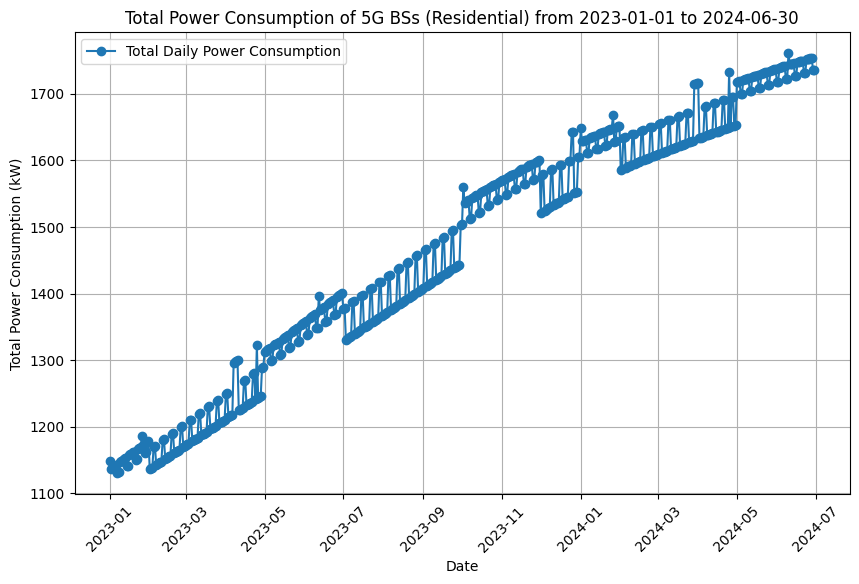

Power consumption data saved to '5G_BS_power_consumption_2023_2024.csv'.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants (replace with actual values)
N_k         = 10  # Number of 5G BSs in the area (N_k)
T_dd_max    = 1000  # Maximum downlink data rate [Mbps] (T_dd_max)
R_ds_max    = 500  # Maximum signaling REs [RE/s] (R_ds,max)
P_max_AAU   = 5  # Maximum power consumption of AAU [kW] (P_max,AAU)
P_b_AAU     = 2  # Baseline power consumption of AAU [kW] (P_b,AAU)
P_b_BBU     = 1  # Baseline power consumption of BBU [kW] (P_b,BBU)
P_ac_pe     = 0.5  # Power consumption of air conditioning and power equipment per BS [kW] (P_ac,pe(t))
A_RE        = 1  # Average amount of downlink data carried per RE [Mbps/RE] (A_RE)
N_m         = 1000  # Monte Carlo sampling times (N_m)
total_population_residential = 3000  # Total number of terminals in the residential area

# Base percentage usage patterns for a typical day (24-hour cycle)
daily_usage_percentage = [8, 3, 2, 1, 0.5, 10, 25, 40, 60, 50, 45, 60, 55, 50, 40, 60, 60, 55, 60, 55, 70, 55, 45, 40]

# Increase factor over time (growing mobile connections)
daily_increase_factor = 0.005  # 0.5% increase in users per day

# Create patterns for specific days like New Year's Eve, New Year's Day, and weekends
holiday_boost_factor = 1.2  # 20% more usage on public holidays
weekend_boost_factor = 1.1  # 10% more usage on weekends
festival_boost_factor = 1.15  # 15% more usage during festivals

# Generate date range from 2023-01-01 to 2024-06-30
start_date = "2023-01-01"
end_date = "2024-06-30"
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Array to store power consumption data for each day
monthly_power_consumption = np.zeros((len(dates), 24))

# List of public holidays in NSW for 2023 and 2024
public_holidays = [
    "2023-01-01",  # New Year's Day
    "2023-01-26",  # Australia Day
    "2023-04-07",  # Good Friday
    "2023-04-08",  # Easter Saturday
    "2023-04-09",  # Easter Sunday
    "2023-04-10",  # Easter Monday
    "2023-04-25",  # Anzac Day
    "2023-06-12",  # King's Birthday
    "2023-10-02",  # Labour Day
    "2023-12-25",  # Christmas Day
    "2023-12-26",  # Boxing Day
    "2024-01-01",  # New Year's Day
    "2024-01-26",  # Australia Day
    "2024-03-29",  # Good Friday
    "2024-03-30",  # Easter Saturday
    "2024-03-31",  # Easter Sunday
    "2024-04-01",  # Easter Monday
    "2024-04-25",  # Anzac Day
    "2024-06-10",  # King's Birthday
    "2024-10-07",  # Labour Day
    "2024-12-25",  # Christmas Day
    "2024-12-26",  # Boxing Day
]

# Festivals: Sydney Festival (January), Vivid Sydney (May-June), Sculpture by the Sea (October-November)
festival_periods = [
    pd.date_range("2023-01-01", "2023-01-31"),  # Sydney Festival
    pd.date_range("2023-05-01", "2023-06-30"),  # Vivid Sydney
    pd.date_range("2023-10-01", "2023-11-30"),  # Sculpture by the Sea
    pd.date_range("2024-01-01", "2024-01-31"),  # Sydney Festival
    pd.date_range("2024-05-01", "2024-06-30"),  # Vivid Sydney
]

# Simulate for each day in the date range
for day_idx, day in enumerate(dates):
    day_of_week = day.weekday()  # Monday = 0, Sunday = 6
    day_str = day.strftime("%Y-%m-%d")
    
    # Adjust for public holidays, weekends, festivals, and general growth over time
    if day_str in public_holidays:  # Public holiday pattern
        usage_pattern = [p * holiday_boost_factor for p in daily_usage_percentage]
    elif day_of_week >= 5:  # Weekend pattern
        usage_pattern = [p * weekend_boost_factor for p in daily_usage_percentage]
    elif any(day in festival for festival in festival_periods):  # Festival pattern
        usage_pattern = [p * festival_boost_factor for p in daily_usage_percentage]
    else:  # Regular weekday pattern
        usage_pattern = daily_usage_percentage

    # Apply daily growth in mobile connections
    growth_factor = 1 + day_idx * daily_increase_factor
    beta_k_t = [int(percentage * total_population_residential * growth_factor / 100) for percentage in usage_pattern]

    # Simulate the power consumption for the residential area for the day
    for t in range(24):  # Simulating each hour in a day
        beta_k_t_s_a = beta_k_t[t]  # Number of activated terminals at hour t

        # Monte Carlo sampling based on Poisson distribution for activated terminals
        beta_k_t_samples = np.random.poisson(beta_k_t_s_a, N_m)

        # Initialize accumulators for Monte Carlo simulation
        T_dd_k_t_sum = 0
        R_ds_k_t_sum = 0

        # Accumulate results for each sample
        for beta_k_t_s_a_sample in beta_k_t_samples:
            T_dd_k_t = min(N_k * T_dd_max, beta_k_t_s_a_sample * A_RE)  # Total downlink data rate (T_dd,k(t))
            R_ds_k_t = min(N_k * R_ds_max, T_dd_k_t / A_RE)  # Downlink signaling REs (R_ds,k(t))
            T_dd_k_t_sum += T_dd_k_t
            R_ds_k_t_sum += R_ds_k_t

        # Average over Monte Carlo samples
        T_dd_k_t_avg = T_dd_k_t_sum / N_m  # Mean downlink data rate
        R_ds_k_t_avg = R_ds_k_t_sum / N_m  # Mean signaling REs

        # Calculate incremental power consumption (Eq. 13, 14)
        P_idd_AAU_k_t = N_k * (P_max_AAU - P_b_AAU) / T_dd_max * (T_dd_k_t_avg / N_k)  # Incremental power due to downlink data
        P_ids_AAU_k_t = N_k * (P_max_AAU - P_b_AAU) / R_ds_max * (R_ds_k_t_avg / N_k)  # Incremental power due to signaling

        # Total incremental power consumption for AAU (Eq. 17)
        P_i_AAU_k_t = P_idd_AAU_k_t + P_ids_AAU_k_t

        # Total power consumption (Eq. 18)
        P_we_k_t = P_i_AAU_k_t + N_k * P_b_AAU + N_k * P_b_BBU

        # Final power consumption including air conditioning (Eq. 19)
        P_we_k_t_total = P_we_k_t + N_k * P_ac_pe

        # Store in the monthly power consumption array
        monthly_power_consumption[day_idx, t] = P_we_k_t_total

# Generate and plot total daily consumption (sum over 24 hours)
daily_totals = np.sum(monthly_power_consumption, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_totals, label="Total Daily Power Consumption", marker='o')

plt.title("Total Power Consumption of 5G BSs (Residential) from 2023-01-01 to 2024-06-30")
plt.xlabel("Date")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Save the power consumption data to a CSV file
power_data = pd.DataFrame(monthly_power_consumption, columns=[f'Hour_{h}' for h in range(1, 25)], index=dates)
power_data['Total_Daily_Consumption'] = daily_totals
power_data.to_csv('5G_BS_power_consumption_2023_2024.csv')

print("Power consumption data saved to '5G_BS_power_consumption_2023_2024.csv'.")

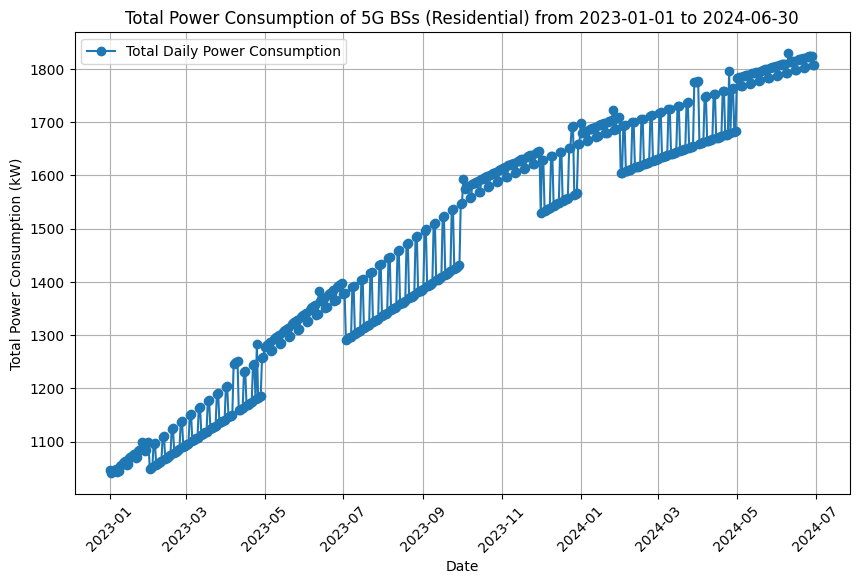

Power consumption data saved to '5G_BS_power_consumption_2023_2024.csv'.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants reflecting Australian mobile data usage
N_k = 10  # Number of 5G BSs in the area (N_k)
T_dd_max = 1000  # Maximum downlink data rate [Mbps] (T_dd_max)
R_ds_max = 500  # Maximum signaling REs [RE/s] (R_ds_max)
P_max_AAU = 5  # Maximum power consumption of AAU [kW] (P_max_AAU)
P_b_AAU = 2  # Baseline power consumption of AAU [kW] (P_b_AAU)
P_b_BBU = 1  # Baseline power consumption of BBU [kW] (P_b_BBU)
P_ac_pe = 0.5  # Power consumption of air conditioning and power equipment per BS [kW] (P_ac_pe(t))
A_RE = 1  # Average amount of downlink data carried per RE [Mbps/RE] (A_RE)
N_m = 1000  # Monte Carlo sampling times (N_m)

# Adjusted population: Assume 1,500 mobile connections in the residential area based on data
total_population_residential = 1500  # Reflects the high mobile penetration in Australia

# Daily usage patterns (percentage) adjusted for peak hours (high streaming and social media activity)
daily_usage_percentage = [10, 5, 3, 2, 1, 15, 30, 50, 70, 60, 55, 75, 70, 65, 50, 75, 75, 65, 75, 70, 85, 70, 55, 50]

# Increased daily growth in mobile users and demand due to mobile data trends
daily_increase_factor = 0.01  # 1% increase in users per day to reflect rapid growth

# Patterns for specific days like New Year's Eve, New Year's Day, and weekends
holiday_boost_factor = 1.3  # 30% more usage on public holidays due to increased demand
weekend_boost_factor = 1.2  # 20% more usage on weekends
festival_boost_factor = 1.25  # 25% more usage during festivals

# Generate date range from 2023-01-01 to 2024-06-30
start_date = "2023-01-01"
end_date = "2024-06-30"
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Array to store power consumption data for each day
monthly_power_consumption = np.zeros((len(dates), 24))

# List of public holidays in NSW for 2023 and 2024
public_holidays = [
    "2023-01-01",  # New Year's Day
    "2023-01-26",  # Australia Day
    "2023-04-07",  # Good Friday
    "2023-04-08",  # Easter Saturday
    "2023-04-09",  # Easter Sunday
    "2023-04-10",  # Easter Monday
    "2023-04-25",  # Anzac Day
    "2023-06-12",  # King's Birthday
    "2023-10-02",  # Labour Day
    "2023-12-25",  # Christmas Day
    "2023-12-26",  # Boxing Day
    "2024-01-01",  # New Year's Day
    "2024-01-26",  # Australia Day
    "2024-03-29",  # Good Friday
    "2024-03-30",  # Easter Saturday
    "2024-03-31",  # Easter Sunday
    "2024-04-01",  # Easter Monday
    "2024-04-25",  # Anzac Day
    "2024-06-10",  # King's Birthday
    "2024-10-07",  # Labour Day
    "2024-12-25",  # Christmas Day
    "2024-12-26",  # Boxing Day
]

# Festivals: Sydney Festival (January), Vivid Sydney (May-June), Sculpture by the Sea (October-November)
festival_periods = [
    pd.date_range("2023-01-01", "2023-01-31"),  # Sydney Festival
    pd.date_range("2023-05-01", "2023-06-30"),  # Vivid Sydney
    pd.date_range("2023-10-01", "2023-11-30"),  # Sculpture by the Sea
    pd.date_range("2024-01-01", "2024-01-31"),  # Sydney Festival
    pd.date_range("2024-05-01", "2024-06-30"),  # Vivid Sydney
]

# Simulate for each day in the date range
for day_idx, day in enumerate(dates):
    day_of_week = day.weekday()  # Monday = 0, Sunday = 6
    day_str = day.strftime("%Y-%m-%d")
    
    # Adjust for public holidays, weekends, festivals, and general growth over time
    if day_str in public_holidays:  # Public holiday pattern
        usage_pattern = [p * holiday_boost_factor for p in daily_usage_percentage]
    elif day_of_week >= 5:  # Weekend pattern
        usage_pattern = [p * weekend_boost_factor for p in daily_usage_percentage]
    elif any(day in festival for festival in festival_periods):  # Festival pattern
        usage_pattern = [p * festival_boost_factor for p in daily_usage_percentage]
    else:  # Regular weekday pattern
        usage_pattern = daily_usage_percentage

    # Apply daily growth in mobile connections
    growth_factor = 1 + day_idx * daily_increase_factor
    beta_k_t = [int(percentage * total_population_residential * growth_factor / 100) for percentage in usage_pattern]

    # Simulate the power consumption for the residential area for the day
    for t in range(24):  # Simulating each hour in a day
        beta_k_t_s_a = beta_k_t[t]  # Number of activated terminals at hour t

        # Monte Carlo sampling based on Poisson distribution for activated terminals
        beta_k_t_samples = np.random.poisson(beta_k_t_s_a, N_m)

        # Initialize accumulators for Monte Carlo simulation
        T_dd_k_t_sum = 0
        R_ds_k_t_sum = 0

        # Accumulate results for each sample
        for beta_k_t_s_a_sample in beta_k_t_samples:
            T_dd_k_t = min(N_k * T_dd_max, beta_k_t_s_a_sample * A_RE)  # Total downlink data rate (T_dd,k(t))
            R_ds_k_t = min(N_k * R_ds_max, T_dd_k_t / A_RE)  # Downlink signaling REs (R_ds,k(t))
            T_dd_k_t_sum += T_dd_k_t
            R_ds_k_t_sum += R_ds_k_t

        # Average over Monte Carlo samples
        T_dd_k_t_avg = T_dd_k_t_sum / N_m  # Mean downlink data rate
        R_ds_k_t_avg = R_ds_k_t_sum / N_m  # Mean signaling REs

        # Calculate incremental power consumption (Eq. 13, 14)
        P_idd_AAU_k_t = N_k * (P_max_AAU - P_b_AAU) / T_dd_max * (T_dd_k_t_avg / N_k)  # Incremental power due to downlink data
        P_ids_AAU_k_t = N_k * (P_max_AAU - P_b_AAU) / R_ds_max * (R_ds_k_t_avg / N_k)  # Incremental power due to signaling

        # Total incremental power consumption for AAU (Eq. 17)
        P_i_AAU_k_t = P_idd_AAU_k_t + P_ids_AAU_k_t

        # Total power consumption (Eq. 18)
        P_we_k_t = P_i_AAU_k_t + N_k * P_b_AAU + N_k * P_b_BBU

        # Final power consumption including air conditioning (Eq. 19)
        P_we_k_t_total = P_we_k_t + N_k * P_ac_pe

        # Store in the monthly power consumption array
        monthly_power_consumption[day_idx, t] = P_we_k_t_total

# Generate and plot total daily consumption (sum over 24 hours)
daily_totals = np.sum(monthly_power_consumption, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_totals, label="Total Daily Power Consumption", marker='o')

plt.title("Total Power Consumption of 5G BSs (Residential) from 2023-01-01 to 2024-06-30")
plt.xlabel("Date")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Save the power consumption data to a CSV file
power_data = pd.DataFrame(monthly_power_consumption, columns=[f'Hour_{h}' for h in range(1, 25)], index=dates)
power_data['Total_Daily_Consumption'] = daily_totals
power_data.to_csv('5G_BS_power_consumption_2023_2024.csv')

print("Power consumption data saved to '5G_BS_power_consumption_2023_2024.csv'.")
